# Switching tasks according to LP in Strategic Learning

[Switching given LP per task](#A1)

[Switching when LP=0](#A2)

[LP where it is most likely for subjects to switch](#A3)

## Set up and imports

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.cm as cm
import pandas as pd
import warnings

from ipywidgets import widgets
from IPython.html.widgets import *

warnings.filterwarnings('ignore')
rcParams.update({'font.size': 15})
#plt.style.use('ggplot')
#plt.style.use('seaborn-dark-palette')
plt.style.use('fivethirtyeight')

import io
from IPython.nbformat import current

def execute_notebook(nbfile):
    
    with io.open(nbfile) as f:
        nb = current.read(f, 'json')
    
    ip = get_ipython()
    
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)

/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python2.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
execute_notebook("Preprocessing.ipynb")

['free']
99
['free', 'train']
99
100
['free', 'test', 'train']
100
101


In [3]:
users = 201
tasks = 4

%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:5000px;  /* output max-height */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

In [4]:
def plotError(window, lookback, plotAll=fixed(False), plotGraph=fixed(False)):
    
    # ===========================================================================================
    # Error Part
    if plotAll:
        # Set up error subplots
        fig = plt.figure(figsize=(15, 15))
        ax, c = [], 0
        for i in range(3):
            for j in range(2):
                ax.append(plt.subplot2grid((3, 2), (i, j)))
                c+=1
                if c == users:
                    break
        plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

    errors=[];
    for u in range(users):
        # With a list in case I want to store them like cumCounts, movAvg should be moved out of this loop though
        # To be indexed by user too
        movAvg=[];
        # Plot error moving average per task for this user u only
        for t in range(tasks):
            # e = 1-accuracy (where accuracy)
            movAvg.append(1-pd.rolling_mean(splitCsvSE[u][splitCsvSE[u][:,1]==t, 2], window)[window-1:]);
            if plotAll:
                ax[u].plot(movAvg[t], label=categories[t])
        errors.append(movAvg);
        if plotAll:
            ax[u].legend()
            ax[u].set_title(''.join(['Person ', str(u+1), ' | Error']))
            ax[u].set_ylabel('Error')
            ax[u].set_xlabel('Task (and window) dependent step ')
    
    if plotAll:
        plt.tight_layout();
        plt.show()
    # Use a global vars so it can retrieve window size and error list to use it with error difference
    global Window
    Window = window
    global Errors
    Errors = errors
    #return errors, window;
    
    # ===========================================================================================
    # LP Part
    def errorChange(arr, lookback=1, getInitDiff=True):
        # Reverse it
        arr = arr[::-1]
        # LP = - [error(now) - error(past)]
        # window: a look-back to consider the difference  diff[t] = a[t] - a[t-window]
        lp = [-i+j for i, j in zip(arr[:-lookback], arr[lookback:])]
        # if it's set to true then it will append the initial (noisy) differences that were left behind by the nature
        # of having a rolling window. Thus it will calculate the differences (only one step) and append them
        if getInitDiff:
            lp += np.diff(arr[-lookback:]).tolist()
        # Reverse it
        lp = lp[::-1]
        return lp

    # Set up subplots for LP
    if plotAll:
        fig = plt.figure(figsize=(15, 15))
        ax, c = [], 0
        for i in range(3):
            for j in range(2):
                ax.append(plt.subplot2grid((3, 2), (i, j)))
                c+=1
                if c == users:
                    break
        plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

    # Store every task LP per user
    lpU = []
    for u in range(users):
        # Stores LP per task for user u
        lpT = []
        for t in range(tasks):
            lpT.append( errorChange(Errors[u][t], lookback, getInitDiff=False) )
            if plotAll:
                # If i make errorChange multidimensional
                #ax[u].plot(lpT[u][t], label=categories[t])
                ax[u].plot(lpT[t], label=categories[t])
                # adjust so it start at 0 when getInitDiff=true
                #ax[u].plot([x for x in range(lookback,lookback+len(lpT))], lpT)
        # Store LP for all t for user u
        lpU.append(lpT)
        if plotAll:
            ax[u].legend()
            ax[u].set_title(''.join(['Person ', str(u+1), ' | Learning Progress']))
            ax[u].set_ylabel('Error rate')
            ax[u].set_xlabel('Task dependent step')

            ax[u].axhline(y=0,xmin=0,xmax=10,c="black",linewidth=0.5,zorder=0)
    
    if plotAll:
        plt.tight_layout()
        plt.show()
    global LPU
    LPU = lpU
    
    
    # ===========================================================================================
    # P(leave|LP) section
    
    # If detached then use global LPU
    #lpU = LPU

    categ = ['Category 1D', 'Category 2D', 'Category Ignore 1D', 'Category Random']
    # Stores lp data per task
    lpTasks = []
    
    for t in range(tasks):
        # One per user
        #color = ['r', 'b', 'k', 'g', 'y']
        color = cm.viridis(np.linspace(0, 1, users))
        
        position = [0, 0.1, 0.2, 0.3, 0.4]
        
        if plotGraph:
            fig, axes = plt.subplots(figsize=(15,10));
            plt.subplots_adjust(wspace=0.5, hspace=0.3);

        # Stores lp data per user
        lpUsers = []
        
        for u in range(users):
            # Now let's see if user continued with the previous task or switched

            # Get unique LP values and counts
            lp, counts = np.unique(lpU[u][t], return_counts=True)
            lpCounts = np.asarray((lp, counts)).T

            # Get the indices for task t
            indT, = np.where(splitCsvSE[u][:,1] == t)

            # Check if we even have LP measurements
            if len(lpU[u][t]) > 0:
                # Then get only those indices to which we have LP measurements
                indTLP = indT[-len(lpU[u][t]):]

                # Concatenate indices for this task with LP, LP and whether or not at this step user u 
                # continued with this same task
                data = [[np.array(indTLP)], [np.array(lpU[u][t]).T], [np.in1d(indTLP+1, indTLP)*1]]
                data = np.concatenate(data).T

                # Discretize the space in 0.05 slices from -0.5 to 0.5
                low, high, step = -0.5, 0.5, 0.05
                # Create bins
                bins = np.arange(low,high,step)
                # Group data in their corresponding bin according to the LP
                binplace = np.digitize(data[:,1], bins)

                # Realign bins
                bins = bins.tolist()
                bins.insert(0, low-step)

                # Now do some binning
                stay = []
                total = []
                pLeave = []
                for b in range(len(bins)):
                    # Go through every bin and get the indices of those that are in the current bin
                    newBins = np.where(binplace == b)
                    # For every bin count the number of times user u continued in this task
                    stay.append(np.sum(data[newBins,2]))
                    total.append(np.size(newBins))
                    # Get P(switch task|LP in this bin)
                    pLeave.append(1-(stay[-1]/total[-1]))
                    
            else:
                low, high, step = -0.5, 0.5, 0.05
                pLeave = [0]*len(np.arange(low,high,step))

            # Plot
            freq = pd.Series.from_array(pLeave)
            
            if plotGraph:
                # format x labels
                x_labels = ["%.2f" % b for b in bins]
                #ax = freq.plot(kind='bar', color=color[u], alpha=0.5, subplots=True, legend=True, 
                #               sharex=False, sharey=False, label=''.join(['Subject ', str(u+1)]), position=position[u]);
                ax = freq.plot(kind='bar', color=color[u], alpha=0.5, subplots=True, legend=True, 
                               sharex=False, sharey=False, label=''.join(['Subject ', str(u+1)]));

                axes.set_xlabel("LP")
                axes.set_ylabel("P(Switch task|LP)")
                axes.set_xticklabels(x_labels);
                axes.set_title(''.join(['Task ', str(t+1), ' | ', categ[t]]));
                axes.set_ylim([0,1])
            
            lpUsers.append(freq.fillna(0))
            #lpUsers.append(freq)
        
        if plotGraph:
            plt.tight_layout();
            plt.show()
        
        lpTasks.append(lpUsers)
    
    return lpTasks

    
 
#errors, window = plotError()
#interact(plotError, window=(1,20))

In [5]:
# Global Variables (Error section)
Window = 20
Errors = []

# Global variables (LP section)
Lookback = 15
LPU = []

freq = plotError(10, 5, False, False)
freq = np.asarray(freq)
freq = np.nan_to_num(freq)
df = pd.DataFrame(np.mean(freq[0,:]))

# for Window in [10, 15, 20, 25, 30, 35, 40]:
#     for Lookback in [2, 5, 10, 15, 20, 25, 30]:
#         print('Window ', Window, ' Lookback LP ', Lookback)
#         plotError(Window, Lookback, False)

<a id='A1'></a>
## Switching task given certain LP

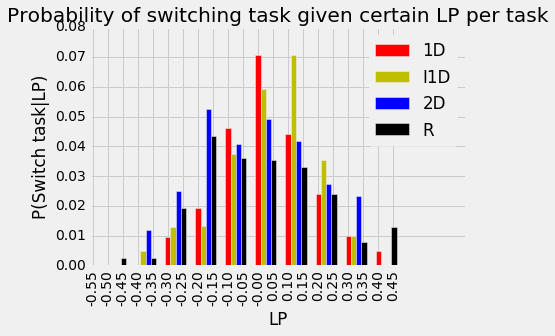

In [6]:
# Discretize the space in 0.05 slices from -0.5 to 0.5
low, high, step = -0.5, 0.5, 0.05
# Create bins
bins = np.arange(low,high,step)

# Realign bins
bins = bins.tolist()
bins.insert(0, low-step)

# format x labels
x_labels = ["%.2f" % b for b in bins]


# Index for barchart
ind = np.arange(len(bins))
width = 0.35 

fig, ax = plt.subplots()

rects1 = ax.bar(ind, np.mean(freq[0,:]), width, color='r',)
rects2 = ax.bar(ind + width, np.mean(freq[1,:]), width, color='y')
rects3 = ax.bar(ind + width*2, np.mean(freq[2,:]), width, color='b')
rects4 = ax.bar(ind + width*3, np.mean(freq[3,:]), width, color='k')

ax.set_ylabel('P(Switch task|LP)')
ax.set_xlabel('LP')
ax.set_title('Probability of switching task given certain LP per task')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(x_labels, rotation='vertical')

ax.legend((rects1[0], rects2[0], rects3[0], rects4[0]), ('1D', 'I1D', '2D', 'R'))

# Store p(switch task|LP=0, task)
onLP0 = []
# Store for which LP the p(switch task|Lp) was the largest
maxLP = []
for t in range(4):
    avg = np.nan_to_num(np.mean(freq[t,:]))
    onLP0.append(avg[11])
    amax = np.argmax(avg)
    maxLP.append(bins[amax])

In [7]:
def plotAgainstTask(arr, title):
    catLab = ['1D', 'I1D', '2D', 'R']
    colors = ["r", "y", "b", "k"]
    fig, ax = plt.subplots(figsize=(5, 5))

    # Control tick frequency
    plt.xticks(np.arange(0, tasks+1, 1.0))
    # Rename ticks
    ax.set_xticklabels(catLab)
    plt.scatter(np.arange(4), arr, c=colors, s=80, alpha=0.5)
    plt.ylabel(title)
    plt.xlabel('Tasks')
    plt.show()

<a id='A2'></a>
## Probability a subject will switch to another task if LP=0

This is calculated on average across subjects.

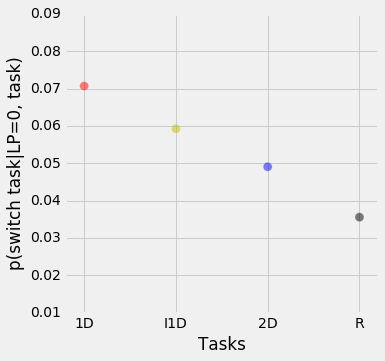

In [8]:
ytitles = ['p(switch task|LP=0, task)', 'LP (when max p(switch task|LP))']
plotAgainstTask(np.asarray(onLP0), ytitles[0])

<a id='A3'></a>
## Under what circumstances (LP) a subject is more likely to switch to another task?

Discretzing the space and on average, for task 1D subjects will switch the most when close to LP=0. For I1D subjects will switch while they still learned LP=0.10. The opposite happens with 2D and R tasks (LP=-0.20).

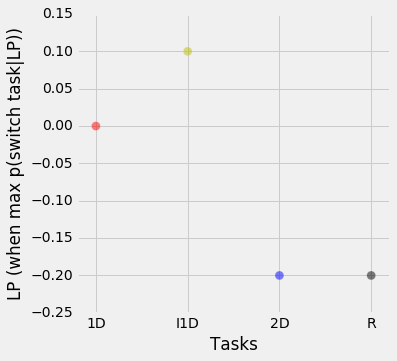

In [9]:
plotAgainstTask(np.asarray(maxLP), ytitles[1])